In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import integrate, optimize
from scipy.interpolate import PchipInterpolator

import warnings, sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# ---------- Paths ----------
EOS_PATH = "/Users/krmt/Desktop/pyTOV-STT/eos_cgs.txt"

# ---------- Physical constants (cgs) ----------
c   = 2.99792458e10          # cm/s
G   = 6.67408e-8             # cgs
Msun= 1.98847e33             # g

# Geometrized length unit (1 Msun in cm)
Length_cm = G*Msun/c**2      # = 1.4766 km in cm
Length_km = Length_cm/1e5

print("Length_km (GM_sun/c^2) =", Length_km)

Length_km (GM_sun/c^2) = 1.476621016665786


In [2]:
# ---------- Load EOS table ----------
# columns: rho_b[g/cm3], (P/c^2)[g/cm3], (eps/c^2)[g/cm3]
data = np.loadtxt(EOS_PATH, comments="#")

rho_b_cgs   = data[:,0]
P_overc2_cgs= data[:,1]
eps_overc2_cgs = data[:,2]

# Recover P and eps in cgs energy density units
P_cgs   = P_overc2_cgs * c**2        # dyn/cm^2  (same as erg/cm^3)
eps_cgs = eps_overc2_cgs * c**2      # erg/cm^3

# ---------- (A) Recommended: consistent geometrized conversion for TOV/STT ----------
# In geometrized units (G=c=1), energy density has dimension 1/length^2.
# Convert cgs energy density [erg/cm^3] -> geom [1/Length^2] with factor (G/c^4)*Length^2
cgs_to_geom_edens = (G / c**4) * (Length_cm**2)

P_geom   = P_cgs   * cgs_to_geom_edens
eps_geom = eps_cgs * cgs_to_geom_edens

# Baryon mass density: [g/cm^3] -> geom [1/Length^2] using (G/c^2)*Length^2
cgs_to_geom_rho = (G / c**2) * (Length_cm**2)
rho_b_geom = rho_b_cgs * cgs_to_geom_rho

# ---------- (B) Your requested factor (kept for reference / optional use) ----------
gcm3_to_MeVfm3 = 5.60958e-13
MeVfm3_to_km2  = 1.323e-6
conversion_factor_user = gcm3_to_MeVfm3 * MeVfm3_to_km2

print("User conversion_factor =", conversion_factor_user)

# Sanity checks
print("EOS table points:", len(P_geom))
print("P_geom range:", P_geom.min(), P_geom.max())
print("eps_geom range:", eps_geom.min(), eps_geom.max())

User conversion_factor = 7.42147434e-19
EOS table points: 172
P_geom range: 5.445137740346693e-25 0.005073890248267606
eps_geom range: 2.1298251428425015e-17 0.005899558198098275


EOS points: 172
P_geom range: 5.441881219003401e-25 0.005070855755353943
eps_geom range: 2.128551378731127e-17 0.005896029905866887


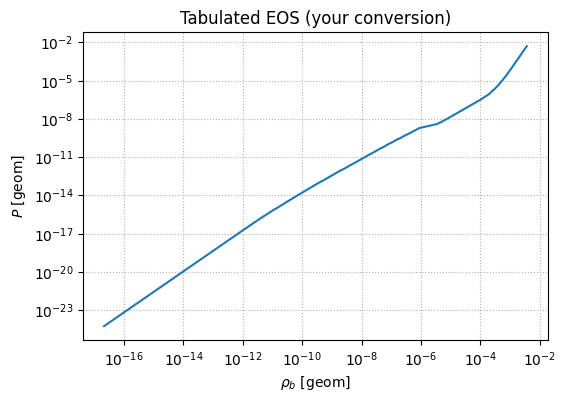

In [3]:
# --- Read EOS table (cgs) ---
data = np.loadtxt(EOS_PATH, comments="#")

rho_b_cgs    = data[:,0]   # g/cm^3  (baryon mass density)
P_overc2_cgs = data[:,1]   # (P/c^2) in g/cm^3
eps_overc2_cgs = data[:,2] # (epsilon/c^2) in g/cm^3  (energy mass density)

# Recover P and eps (as mass density units g/cm^3)
# (Because P/c^2 is given. In geometrized units, P and eps share same units.)
P_mass_cgs   = P_overc2_cgs
eps_mass_cgs = eps_overc2_cgs

# --- Your requested conversion to geometrized units ---
# Given:
gcm3_to_MeVfm3 = 5.60958e-13
MeVfm3_to_km2  = 1.323e-6
conversion_factor = gcm3_to_MeVfm3 * MeVfm3_to_km2   # (g/cm^3) -> (km^-2) effectively (as you intend)

# Convert km^-2 -> (Length_unit)^-2 where Length_unit = GM_sun/c^2 in km
km2_to_geom = (Length_km**2)  # 1 geom_length^2 = Length_km^2 km^2
cgs_to_geom = conversion_factor * km2_to_geom

P_geom   = P_mass_cgs   * cgs_to_geom
eps_geom = eps_mass_cgs * cgs_to_geom
rho_b_geom = rho_b_cgs  * cgs_to_geom  # if you want baryon density in same unit

# Sort by pressure for monotone interpolation
idx = np.argsort(P_geom)
P_tab   = P_geom[idx]
eps_tab = eps_geom[idx]
rho_tab = rho_b_geom[idx]

# Remove duplicates (required by interpolator)
P_unique, iu = np.unique(P_tab, return_index=True)
eps_unique = eps_tab[iu]
rho_unique = rho_tab[iu]

from scipy.interpolate import PchipInterpolator

eps_of_P_interp = PchipInterpolator(P_unique, eps_unique, extrapolate=False)
rho_of_P_interp = PchipInterpolator(P_unique, rho_unique, extrapolate=False)
P_of_eps_interp = PchipInterpolator(eps_unique, P_unique, extrapolate=False)

def eps_of_P(P):
    P = np.clip(P, P_unique[0], P_unique[-1])
    return float(eps_of_P_interp(P))

def rho_of_P(P):
    P = np.clip(P, P_unique[0], P_unique[-1])
    return float(rho_of_P_interp(P))

def P_of_eps(eps):
    eps = np.clip(eps, eps_unique[0], eps_unique[-1])
    return float(P_of_eps_interp(eps))

print("EOS points:", len(P_unique))
print("P_geom range:", P_unique.min(), P_unique.max())
print("eps_geom range:", eps_unique.min(), eps_unique.max())

plt.figure(figsize=(6,4))
plt.loglog(rho_unique, P_unique)
plt.xlabel(r'$\rho_b$ [geom]')
plt.ylabel(r'$P$ [geom]')
plt.title("Tabulated EOS (your conversion)")
plt.grid(True, which="both", ls=":")
plt.show()

In [4]:
def A_of_phi(phi, beta):
    return np.exp(0.5*beta*phi**2)

def alpha_of_phi(phi, beta):
    return beta*phi

In [5]:
def f_int(r, y, beta, mphi):
    # y = [P, m, nu, phi, psi]
    P, m, nu, phi, psi = y

    if r == 0.0:
        r = 1e-12

    eps = eps_of_P(P)
    V = 2.0 * (mphi**2) * (phi**2)
    A = A_of_phi(phi, beta)
    alpha = alpha_of_phi(phi, beta)

    r_minus_2m = r - 2.0*m
    if abs(r_minus_2m) < 1e-16:
        r_minus_2m = np.sign(r_minus_2m) * 1e-16 if r_minus_2m != 0 else 1e-16

    denom = r * r_minus_2m

    dPdr = -(eps + P) * (
        (m + 4.0*np.pi*A**4*(r**3)*P)/denom
        + 0.5*r*(psi**2) + alpha*psi
    )

    dmdr = 4.0*np.pi*A**4*(r**2)*eps + 0.5*r*(r-2.0*m)*(psi**2) + 0.25*(r**2)*V

    dnudr = (
        2.0*(m + 4.0*np.pi*A**4*(r**3)*P)/denom
        + r*(psi**2)
        - 0.25*(r**2)*V/(r_minus_2m)
    )

    dphidr = psi

    dpsidr_massless = (
        4.0*np.pi*A**4*r/(r_minus_2m) * (alpha*(eps-3.0*P) + r*(eps-P)*psi)
        - 2.0*(r-m)*psi/denom
    )

    mass_term = - (r/(r_minus_2m)) * (mphi**2) * phi
    dpsidr = dpsidr_massless - mass_term

    return [dPdr, dmdr, dnudr, dphidr, dpsidr]


def f_ext(r, y, beta, mphi):
    # y = [P=0, m, nu, phi, psi]
    P, m, nu, phi, psi = y

    if r == 0.0:
        r = 1e-12

    r_minus_2m = r - 2.0*m
    if abs(r_minus_2m) < 1e-16:
        r_minus_2m = np.sign(r_minus_2m) * 1e-16 if r_minus_2m != 0 else 1e-16

    V = 2.0*(mphi**2)*(phi**2)

    dPdr = 0.0
    dmdr = 0.5*r*(r-2.0*m)*(psi**2) + 0.25*(r**2)*V
    dnudr = 2.0*m/(r*(r-2.0*m)) + r*(psi**2) - 0.25*(r**2)*V/(r_minus_2m)
    dphidr = psi

    dpsidr_massless = -2.0*(r-m)*psi/(r*(r-2.0*m))
    mass_term = - (r/(r_minus_2m))*(mphi**2)*phi
    dpsidr = dpsidr_massless - mass_term

    return [dPdr, dmdr, dnudr, dphidr, dpsidr]

In [6]:
from scipy import integrate, optimize

def solve_star_shooting(P_c, beta, mphi,
                        N=16001, r_max=250.0,
                        initial_params=(-1.0, -0.1),
                        rtol=1e-10, atol=1e-35,
                        maxiter=200):

    r = np.linspace(0.0, r_max, N)
    dr = r[1] - r[0]

    def integrate_profile(nu_c, phi_c):
        y = np.zeros((N,5))
        y[0,:] = [P_c, 0.0, nu_c, phi_c, 0.0]

        ode = integrate.ode(lambda rr, yy: f_int(rr, yy, beta, mphi))
        ode.set_integrator('lsoda', rtol=rtol, atol=atol)
        ode.set_initial_value([P_c, 0.0, nu_c, phi_c, 0.0], dr)

        idx = 1
        # interior
        while ode.successful() and ode.t < r[-1] and ode.y[0] > 0.0 and idx < N:
            y[idx,:] = ode.y
            ode.integrate(ode.t + dr)
            idx += 1

        idx_surface = idx-1
        if idx_surface < 10 or idx_surface >= N-10:
            return None

        # exterior
        y0ext = y[idx_surface,:].copy()
        y0ext[0] = 0.0

        ode = integrate.ode(lambda rr, yy: f_ext(rr, yy, beta, mphi))
        ode.set_integrator('lsoda', rtol=rtol, atol=atol)
        ode.set_initial_value(y0ext, r[idx_surface])

        idx2 = idx_surface
        while ode.successful() and ode.t < r[-1] and idx2 < N:
            y[idx2,:] = ode.y
            ode.integrate(ode.t + dr)
            idx2 += 1

        return r, y, idx_surface, idx2

    def objective(params):
        nu_c, phi_c = params
        out = integrate_profile(nu_c, phi_c)
        if out is None:
            return 1e99
        rgrid, y, idx_surface, idx2 = out
        k = min(N-2, idx2-2)
        nu_inf = y[k,2]
        phi_inf = y[k,3]
        return np.sqrt(nu_inf**2 + phi_inf**2)

    opt = optimize.minimize(
        objective,
        np.array(initial_params, dtype=float),
        method="nelder-mead",
        options={"maxiter": maxiter, "xatol": 1e-8, "fatol": 1e-10}
    )

    nu_c, phi_c = opt.x
    out = integrate_profile(nu_c, phi_c)
    if out is None:
        raise RuntimeError("Final integration failed.")

    rgrid, y, idx_surface, idx2 = out
    R_coord = rgrid[idx_surface]
    phi_surface = y[idx_surface,3]
    R_phys = A_of_phi(phi_surface, beta) * R_coord
    R_km = R_phys * Length_km

    # asymptotic mass from nu'(r) (reference notebook style)
    nu_prof = y[:,2]
    dnudr = np.gradient(nu_prof, dr, edge_order=2)
    k = min(N-4, idx2-4)
    M_asymp = dnudr[k] * rgrid[k]**2 * np.exp(nu_prof[k]) / 2.0

    sol = {
        "r": rgrid, "y": y,
        "idx_surface": idx_surface,
        "R_km": R_km,
        "M": M_asymp,
        "nu_c": nu_c, "phi_c": phi_c,
        "phi_inf": y[min(N-2, idx2-2), 3],
        "opt": opt
    }
    return M_asymp, R_km, sol

In [7]:
def MR_curve_one_combo_shooting(beta, mphi,
                                n_points=60,
                                frac_min=0.70, frac_max=0.985,
                                N=16001, r_max=250.0,
                                init_params=(-1.0, -0.1),
                                phi_min=1e-5,
                                phi_seeds=None,
                                maxiter=220):

    if phi_seeds is None:
        phi_seeds = (-3e-1, -2e-1, -1e-1, -5e-2, -1e-2, -1e-3,
                     +1e-3, +1e-2, +5e-2, +1e-1, +2e-1, +3e-1)

    eps_c_list = np.linspace(
        eps_unique[int(frac_min*len(eps_unique))],
        eps_unique[int(frac_max*len(eps_unique))],
        n_points
    )

    M_list, R_list = [], []
    nu_guess = float(init_params[0])

    for i, eps_c in enumerate(eps_c_list):
        P_c = P_of_eps(eps_c)
        best = None   
        tried = 0
        accepted = 0

        for phi0 in phi_seeds:
            tried += 1
            try:
                M, R_km, sol = solve_star_shooting(
                    P_c, beta=beta, mphi=mphi,
                    N=N, r_max=r_max,
                    initial_params=(nu_guess, float(phi0)),
                    maxiter=maxiter
                )
                
                # --- THE SANITY FILTER (The only change) ---
                # This ignores the "absurd" solutions (negative mass, tiny radius, exploding field)
                if M <= 0.0 or R_km < 5.0 or abs(sol['phi_inf']) > 1e-2:
                    continue
                # -------------------------------------------

                if abs(sol["phi_c"]) < phi_min:
                    continue

                accepted += 1
                score = abs(sol["phi_inf"])

                if (best is None) or (score < best[0]):
                    best = (score, M, R_km, sol)
            except Exception:
                continue

        if best is None:
            print(f"[{i+1:03d}/{len(eps_c_list)}] beta={beta}, mphi={mphi} eps_c={eps_c:.3e} -> "
                  f"NO scalarized solution found (accepted {accepted}/{tried})")
            continue

        score, M, R_km, sol = best
        nu_guess = sol["nu_c"]   

        M_list.append(M)
        R_list.append(R_km)

        print(f"[{i+1:03d}/{len(eps_c_list)}] beta={beta}, mphi={mphi} eps_c={eps_c:.3e} -> "
              f"M={M:.3f} Msun, R={R_km:.2f} km, phi_c={sol['phi_c']:.3e}, |phi_inf|={abs(sol['phi_inf']):.3e} "
              f"(accepted {accepted}/{tried})")

    return np.array(M_list), np.array(R_list)

[001/60] beta=-6.0, mphi=0.02 eps_c=1.229e-03 -> NO scalarized solution found (accepted 0/12)
[002/60] beta=-6.0, mphi=0.02 eps_c=1.303e-03 -> NO scalarized solution found (accepted 0/12)
[003/60] beta=-6.0, mphi=0.02 eps_c=1.377e-03 -> M=1.081 Msun, R=11.31 km, phi_c=-5.681e-02, |phi_inf|=7.817e-12 (accepted 6/12)
[004/60] beta=-6.0, mphi=0.02 eps_c=1.450e-03 -> M=1.123 Msun, R=11.24 km, phi_c=-9.206e-02, |phi_inf|=5.906e-11 (accepted 2/12)
[005/60] beta=-6.0, mphi=0.02 eps_c=1.524e-03 -> M=1.172 Msun, R=11.22 km, phi_c=-1.174e-01, |phi_inf|=1.673e-10 (accepted 2/12)
[006/60] beta=-6.0, mphi=0.02 eps_c=1.598e-03 -> M=1.228 Msun, R=11.22 km, phi_c=-1.382e-01, |phi_inf|=1.139e-10 (accepted 6/12)
[007/60] beta=-6.0, mphi=0.02 eps_c=1.671e-03 -> M=1.291 Msun, R=11.24 km, phi_c=-1.560e-01, |phi_inf|=3.136e-11 (accepted 4/12)
[008/60] beta=-6.0, mphi=0.02 eps_c=1.745e-03 -> M=1.361 Msun, R=11.30 km, phi_c=-1.715e-01, |phi_inf|=2.595e-11 (accepted 4/12)
[009/60] beta=-6.0, mphi=0.02 eps_c=1.

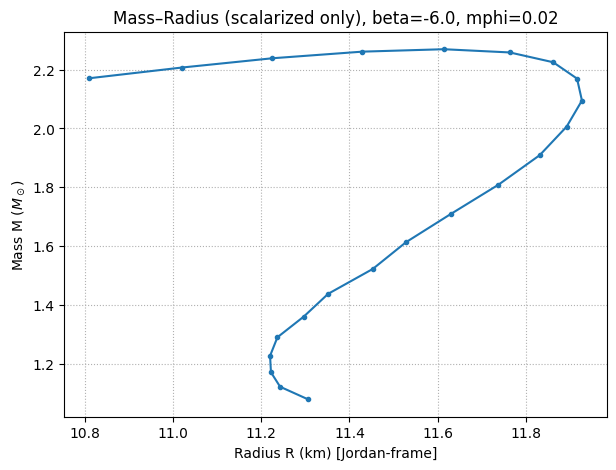

In [8]:
beta = -6.0
mphi = 2e-2

M, R = MR_curve_one_combo_shooting(
    beta=beta, mphi=mphi,
    n_points=60,
    N=16001, r_max=250.0,
    init_params=(-1.0, -0.2),   # nu seed matters; phi is handled by phi_seeds
    phi_min=1e-5,
    maxiter=220
)

plt.figure(figsize=(7,5))
plt.plot(R, M, "o-", ms=3)
plt.xlabel("Radius R (km) [Jordan-frame]")
plt.ylabel(r"Mass M ($M_\odot$)")
plt.title(f"Mass–Radius (scalarized only), beta={beta}, mphi={mphi}")
plt.grid(True, ls=":")
plt.show()